# Рекомендация тарифов

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования** - построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

### Описание данных

- `сalls` — количество звонков
- `minutes` — суммарная длительность звонков в минутах
- `messages` — количество sms-сообщений
- `mb_used` — израсходованный интернет-трафик в Мб
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## План исследования

- [1. Исследовательский анализ данных](#глава1)  
    - [1.1 Загрузка данных](#раздел1.1)  
    - [1.2 Информациях о тарифах](#раздел1.2)  
- [2. Выбор и обучение модели](#глава2)  
    - [2.1 Разделение исходных данных на обучающую, валидационную и тестовую выборки](#раздел2.1)  
    - [2.2 Модель решающего дерева](#раздел2.2)  
    - [2.3 Модель случайного леса](#раздел2.3)  
- [3. Проверка качества модели на тестовой выборке](#глава3)  
- [4. Вывод](#глава4)

<a id='глава1'></a>
# 1. Исследовательский анализ данных

<a id='раздел1.1'></a>
## 1.1 Загрузка данных

Выгрузим данные таблицы в следующий датафрейм:

data - users_behavior.csv

In [3]:
# Импорт необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# Загрузка файла данных

data_path_local = 'C:/Users/Asus3/Documents/Яндекс.Практикум/projects/data/project_6/users_behavior.csv'
#данные локально
'''
data_path_local = 'C:/Users/ruleva_ad/Desktop/projects/data/project_6/users_behavior.csv'
data_path_local = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/project_6/users_behavior.csv'
'''
#данные на сервере
data_path_server = '/datasets/users_behavior.csv'
    
if os.path.exists(data_path_local):
    data = pd.read_csv(data_path_local, sep=',')
    print('Успешное чтение файлов')
elif os.path.exists(data_path_server):
    data = pd.read_csv(data_path_server, sep=',')
else:
    print('Путь к файлу не найден')

Успешное чтение файлов


In [5]:
pd.set_option('display.max_columns', None)

<a id='раздел1.2'></a>
## 1.2 Информация о тарифах:

In [6]:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод

Данные выгружены успешно. По условиям задачи предварительная обработка не требуется. Целевой признак- `is_ultra`, категориальный.

<a id='раздел1.2.1'></a>
### 1.2.1 Столбец `calls` :

In [8]:
data['calls'].describe()

count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

Text(0.5, 1.0, 'Количество звонков')

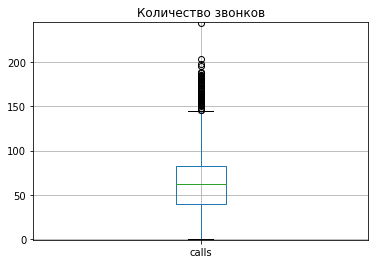

In [9]:
plt.ylim(-1, 245)
data.boxplot(column=['calls'])
plt.title('Количество звонков')

Видим, что в данных есть небольшие выбросы.

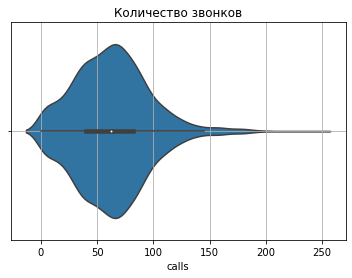

In [10]:
sns.violinplot(x='calls', data=data)
plt.title('Количество звонков')
plt.grid()
plt.show()

<a id='раздел1.2.2'></a>
### 1.2.2 Столбец `minutes` :

In [11]:
# minutes
data['minutes'].describe()

count    3214.000000
mean      438.208787
std       234.569872
min         0.000000
25%       274.575000
50%       430.600000
75%       571.927500
max      1632.060000
Name: minutes, dtype: float64

Text(0.5, 1.0, 'Количество потраченных минут')

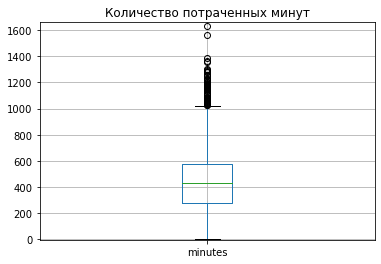

In [12]:
plt.ylim(-5, 1660)
data.boxplot(column=['minutes'])
plt.title('Количество потраченных минут')

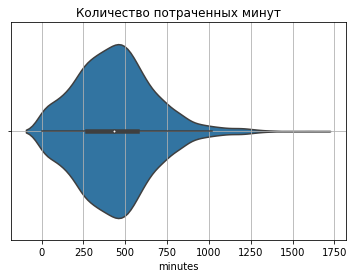

In [13]:
sns.violinplot(x='minutes', data=data)
plt.title('Количество потраченных минут')
plt.grid()
plt.show()

<a id='раздел1.2.3'></a>
### 1.2.3 Столбец `messages` :

In [14]:
#  messages
data['messages'].describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

Text(0.5, 1.0, 'Количество потраченных сообщений')

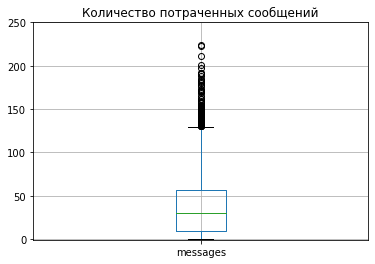

In [15]:
plt.ylim(-1, 250)
data.boxplot(column=['messages'])
plt.title('Количество потраченных сообщений')

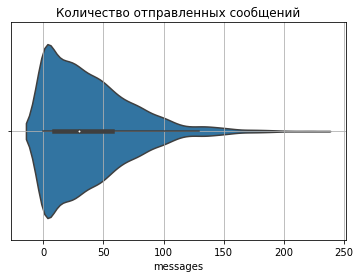

In [16]:
sns.violinplot(x='messages', data=data)
plt.title('Количество отправленных сообщений')
plt.grid()
plt.show()

<a id='раздел1.2.4'></a>
### 1.2.4 Столбец `mb_used` :

In [17]:
#  mb_used
data['mb_used'].describe()

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

Text(0.5, 1.0, 'Количество потраченного трафика')

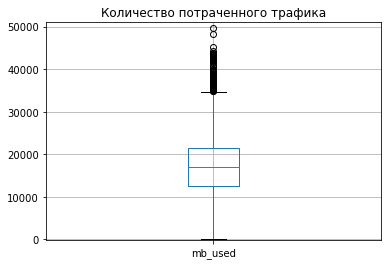

In [18]:
plt.ylim(-100, 51000)
data.boxplot(column=['mb_used'])
plt.title('Количество потраченного трафика')

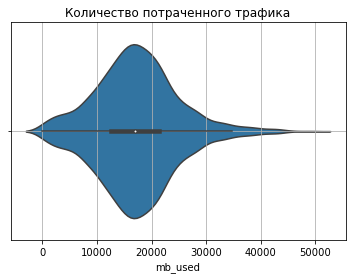

In [19]:
sns.violinplot(x='mb_used', data=data)
plt.title('Количество потраченного трафика')
plt.grid()
plt.show()

<a id='раздел1.2.5'></a>
### 1.2.5 Столбец `is_ultra` :

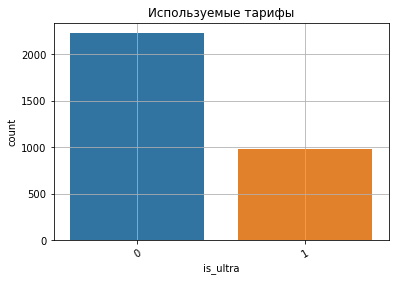

In [20]:
# sns.set(style="darkgrid")
# ax = sns.countplot(x="is_ultra", data=data)

sns.countplot(x='is_ultra',  data=data)
plt.xticks(rotation = 30)
plt.title('Используемые тарифы')
plt.grid()
plt.show()

### Вывод

В данных есть выбросы, это может снизить качество модели, но по условию задачи предварительная обработка не требуется. Целевой признак- `is_ultra`, категориальный.

<a id='глава2'></a>
# 2. Выбор и обучение модели

<a id='раздел2.1'></a>
## 2.1 Разделение исходных данных на обучающую, валидационную и тестовую выборки.

Данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов равны.

Разделение производим в пропорции 3:1:1.

In [21]:
data_train, data_all_valid = train_test_split(data, test_size=0.4, random_state=12345) 
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']
data_valid, data_test = train_test_split(data_all_valid, test_size=0.5, random_state=12345) 
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

**Вывод**

Разделение произведено успешно.

<a id='раздел2.2'></a>
## 2.2 Модель решающего дерева

In [22]:
best_decision_tree_model = None
best_decision_tree_result = 0
best_decision_tree_depth = 0
for depth in range(1, 6):
    decision_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_tree_model.fit(features_train, target_train)
    predictions = decision_tree_model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions) 
    if result > best_decision_tree_result:
        best_decision_tree_model = decision_tree_model
        best_decision_tree_result = result  
        best_decision_tree_depth = depth
        
print("Accuracy лучшей модели:", best_decision_tree_result, "\nDepth лучшей модели:", best_decision_tree_depth)

Accuracy лучшей модели: 0.7853810264385692 
Depth лучшей модели: 3


<a id='раздел2.3'></a>
## 2.3 Модель случайного леса

In [34]:
best_random_forest_model = None
best_random_forest_result = 0
best_random_forest_est = 0
for est in range(1, 20):
    random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    random_forest_model.fit(features_train, target_train)
    result = random_forest_model.score(features_valid, target_valid)
    if result > best_random_forest_result:
        best_random_forest_model = random_forest_model
        best_random_forest_result = result
        best_random_forest_est = est

print("Accuracy наилучшей модели на валидационной выборке:", best_random_forest_result, "\nEst лучшей модели:", best_random_forest_est)

Accuracy наилучшей модели на валидационной выборке: 0.7931570762052877 
Est лучшей модели: 18


<a id='раздел2.4'></a>
## 2.4 Модель логистической регрессии

In [35]:
best_logistic_regression_model = None
best_logistic_regression_result = 0
best_logistic_regression_iter = 0
for i in range(100, 1000, 100):
    logistic_regression_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=i)
    logistic_regression_model.fit(features_train, target_train)
    predictions = logistic_regression_model.predict(features_valid)
    result = logistic_regression_model.score(features_valid, target_valid)
    if result > best_logistic_regression_result:
        best_logistic_regression_model = logistic_regression_model
        best_logistic_regression_result = result
        best_logistic_regression_iter = i

print("Accuracy наилучшей модели на валидационной выборке:", best_logistic_regression_result, "\nIter лучшей модели:", best_logistic_regression_iter)

Accuracy наилучшей модели на валидационной выборке: 0.7107309486780715 
Iter лучшей модели: 100


**Вывод**

Наилучшей одинаковой точностью на валидационной выборке обладают модели решающего древа (при max_depth = 3) и случайного леса (при n_estimators = 18): Accuracy наилучшей модели на валидационной выборке = 0.7931570762052877.

Для модели логистической регрессии Accuracy наилучшей модели (при max_iter = 100) на валидационной выборке = 0.7107309486780715, что хуже результатов предыдущих моделей.

<a id='глава3'></a>
# 3. Проверка качества модели на тестовой выборке

Сравним качество модели случайного леса на тестовой выборке:

In [39]:
result = best_random_forest_model.score(features_test, target_test)
print('Accuracy наилучшей модели на тестовой выборке:', result)

Accuracy наилучшей модели на тестовой выборке: 0.7853810264385692


<a id='глава4'></a>
# 4. Вывод

Результаты, полученые на тестовой выборке, схожи с результатами, полученным на валидационной выборке:  Accuracy наилучшей модели на валидационной выборке = 0.7931570762052877, Accuracy наилучшей модели на тестовой выборке: 0.7869362363919129

In [40]:
#<a id='раздел3.1'></a>
## 3.1 Наилучшая модель решающего дерева.
# predictions = best_decision_tree_model.predict(features_test) 
# result = accuracy_score(target_test, predictions) 
# print("Accuracy наилучшей модели на тестовой выборке:", result)


#<a id='раздел3.2'></a>
## 3.2 Наилучшая модель случайного леса
#result = best_random_forest_model.score(features_test, target_test)
#print('Accuracy наилучшей модели на тестовой выборке:', result)

#<a id='раздел3.3'></a>
## 3.3 Наилучшая модель логистической регрессии
# predictions = best_logistic_regression_model.predict(features_test)
# result = best_logistic_regression_model.score(features_test, target_test)
# print('Accuracy наилучшей модели на тестовой выборке:', result)